In [1]:
# Import Libraries #
import findspark
findspark.init()
from pyspark.sql.functions import split, col, array_contains, translate, round, size, when, udf, lit, mean, count, format_number, collect_list
from pyspark.sql.types import TimestampType, MapType, IntegerType, StringType, ArrayType, FloatType, StructField, StructType
from pyspark.sql import SparkSession
from helper import *
import logging

spark = SparkSession.builder.appName('test').master("yarn") \
.config("spark.executor.instances", 12) \
.config("spark.executor.memory", "1G")  \
.getOrCreate()
## MUTE OUTPUT FROM SPARK
logger = spark._jvm.org.apache.log4j
logger.LogManager.getLogger("org").setLevel(logger.Level.OFF)
logger.LogManager.getLogger("akka").setLevel(logger.Level.OFF)
spark.conf.set("spark.driver.log.level", "OFF")
#Event, White, Black, Result, WhiteElo, BlackElo, Opening, TimeControl, Termination, Moves,Eval, UTCTimestamp
schema = StructType([ \
    StructField("Event",StringType(),True), \
    StructField("White",StringType(),True), \
    StructField("Black",StringType(),True), \
    StructField("Result", StringType(), True), \
    StructField("WhiteElo", IntegerType(), True), \
    StructField("BlackElo", IntegerType(), True), \
    StructField("Opening",StringType(),True), \
    StructField("TimeControl",StringType(),True), \
    StructField("Termination",StringType(),True), \
    StructField("Moves", StringType(), True), \
    StructField("Eval", StringType(), True), \
    StructField("UTCTimestamp", TimestampType(), True) \
  ])
df = spark.read.csv("hdfs://namenode:9000/chess_2016_dataset/output/part*", schema=schema)

2023-04-14 13:10:25,507 INFO spark.SparkContext: Running Spark version 3.3.2
2023-04-14 13:10:26,366 INFO resource.ResourceUtils: ==============================================================
2023-04-14 13:10:26,367 INFO resource.ResourceUtils: No custom resources configured for spark.driver.
2023-04-14 13:10:26,368 INFO resource.ResourceUtils: ==============================================================
2023-04-14 13:10:26,370 INFO spark.SparkContext: Submitted application: test
2023-04-14 13:10:26,416 INFO resource.ResourceProfile: Default ResourceProfile created, executor resources: Map(cores -> name: cores, amount: 1, script: , vendor: , memory -> name: memory, amount: 1024, script: , vendor: , offHeap -> name: offHeap, amount: 0, script: , vendor: ), task resources: Map(cpus -> name: cpus, amount: 1.0)
2023-04-14 13:10:26,444 INFO resource.ResourceProfile: Limiting resource is cpus at 1 tasks per executor
2023-04-14 13:10:26,448 INFO resource.ResourceProfileManager: Added Resou

In [2]:
spark

##### Check Shape of Data

In [3]:
print("shape: ", (df.count(), len(df.columns)))

2023-04-14 13:11:04,405 INFO datasources.FileSourceStrategy: Pushed Filters: 
2023-04-14 13:11:04,408 INFO datasources.FileSourceStrategy: Post-Scan Filters: 
2023-04-14 13:11:04,410 INFO datasources.FileSourceStrategy: Output Data Schema: struct<>
2023-04-14 13:11:05,348 INFO codegen.CodeGenerator: Code generated in 313.365051 ms
2023-04-14 13:11:05,474 INFO memory.MemoryStore: Block broadcast_0 stored as values in memory (estimated size 487.1 KiB, free 92.8 MiB)
2023-04-14 13:11:05,613 INFO memory.MemoryStore: Block broadcast_0_piece0 stored as bytes in memory (estimated size 54.0 KiB, free 92.8 MiB)
2023-04-14 13:11:05,619 INFO storage.BlockManagerInfo: Added broadcast_0_piece0 in memory on namenode:45907 (size: 54.0 KiB, free: 93.2 MiB)
2023-04-14 13:11:05,630 INFO spark.SparkContext: Created broadcast 0 from count at NativeMethodAccessorImpl.java:0
2023-04-14 13:11:05,678 INFO execution.FileSourceScanExec: Planning scan with bin packing, max size: 4194304 bytes, open cost is consi

shape:  (1000, 12)


2023-04-14 13:11:11,539 INFO scheduler.TaskSetManager: Finished task 0.0 in stage 2.0 (TID 1) in 1628 ms on datanode3 (executor 5) (1/1)
2023-04-14 13:11:11,540 INFO cluster.YarnScheduler: Removed TaskSet 2.0, whose tasks have all completed, from pool 
2023-04-14 13:11:11,545 INFO scheduler.DAGScheduler: ResultStage 2 (count at NativeMethodAccessorImpl.java:0) finished in 1.658 s
2023-04-14 13:11:11,550 INFO scheduler.DAGScheduler: Job 1 is finished. Cancelling potential speculative or zombie tasks for this job
2023-04-14 13:11:11,551 INFO cluster.YarnScheduler: Killing all running tasks in stage 2: Stage finished
2023-04-14 13:11:11,553 INFO scheduler.DAGScheduler: Job 1 finished: count at NativeMethodAccessorImpl.java:0, took 1.706121 s


##### Convert columns to appropriate types

In [4]:
df = convert_types(df)
df.dtypes

[('Event', 'string'),
 ('White', 'string'),
 ('Black', 'string'),
 ('Result', 'string'),
 ('WhiteElo', 'int'),
 ('BlackElo', 'int'),
 ('Opening', 'string'),
 ('TimeControl', 'string'),
 ('Termination', 'string'),
 ('Moves', 'array<string>'),
 ('Eval', 'array<float>'),
 ('UTCTimestamp', 'timestamp')]

In [5]:
eval_difference = 3.0
eval_games = df.where(col("Eval")[0].isNotNull())
eval_games = eval_games.withColumn("WhiteBlunders", (find_white_blunders(col("Eval"), lit(eval_difference))))
eval_games = eval_games.withColumn("BlackBlunders", (find_black_blunders(col("Eval"), lit(eval_difference))))
eval_games.select("TimeControl", "White", "WhiteElo", "WhiteBlunders", "Black", "BlackElo", "BlackBlunders", "Result", "Termination") \
    .orderBy(col("WhiteBlunders").desc(), col("BlackBlunders").desc()).limit(10).toPandas().head(10)

2023-04-14 13:11:12,667 INFO datasources.FileSourceStrategy: Pushed Filters: IsNotNull(Eval)
2023-04-14 13:11:12,668 INFO datasources.FileSourceStrategy: Post-Scan Filters: isnotnull(Eval#10),isnotnull(cast(split(translate(Eval#10, ', ), ,, -1) as array<float>)[0])
2023-04-14 13:11:12,669 INFO datasources.FileSourceStrategy: Output Data Schema: struct<White: string, Black: string, Result: string, WhiteElo: int, BlackElo: int ... 6 more fields>
2023-04-14 13:11:12,750 INFO codegen.CodeGenerator: Code generated in 26.862515 ms
2023-04-14 13:11:12,794 INFO codegen.CodeGenerator: Code generated in 25.711475 ms
2023-04-14 13:11:12,900 INFO codegen.CodeGenerator: Code generated in 75.700347 ms
2023-04-14 13:11:12,908 INFO memory.MemoryStore: Block broadcast_3 stored as values in memory (estimated size 487.1 KiB, free 92.3 MiB)
2023-04-14 13:11:12,942 INFO memory.MemoryStore: Block broadcast_3_piece0 stored as bytes in memory (estimated size 54.0 KiB, free 92.2 MiB)
2023-04-14 13:11:12,943 IN

,TimeControl,White,WhiteElo,WhiteBlunders,Black,BlackElo,BlackBlunders,Result,Termination
0,600+0,dwp5321,1362,12,jujugaga,1295,9,1/2-1/2,Normal
1,480+0,joelbackman,1660,7,Rainbow52,1698,4,1/2-1/2,Time forfeit
2,300+0,hritic333,1812,5,jessehf,1799,2,0-1,Normal
3,90+0,Bogomdan,1380,5,prefe,1646,2,0-1,Time forfeit
4,600+0,dominguez1986,2005,4,yamyam15,1837,5,1-0,Normal
5,60+0,StEustache,1841,4,anirudhmehra,1545,3,1-0,Time forfeit
6,180+0,zelenimatej,1875,4,Andre_Sky,1672,3,1-0,Time forfeit
7,600+0,M_as19,1217,4,WattstheLoveguru,1288,2,0-1,Normal
8,900+5,venerabile48,1946,4,meev,1965,1,0-1,Normal
9,900+0,Sahinsah,1639,3,aerdna87,1634,9,1-0,Normal


##### Plot Most Blundered Game

2023-04-14 13:11:18,174 INFO datasources.FileSourceStrategy: Pushed Filters: IsNotNull(Eval)
2023-04-14 13:11:18,176 INFO datasources.FileSourceStrategy: Post-Scan Filters: isnotnull(Eval#10),isnotnull(cast(split(translate(Eval#10, ', ), ,, -1) as array<float>)[0])
2023-04-14 13:11:18,177 INFO datasources.FileSourceStrategy: Output Data Schema: struct<Eval: string>
2023-04-14 13:11:18,253 INFO codegen.CodeGenerator: Code generated in 27.897948 ms
2023-04-14 13:11:18,336 INFO codegen.CodeGenerator: Code generated in 71.837966 ms
2023-04-14 13:11:18,343 INFO memory.MemoryStore: Block broadcast_5 stored as values in memory (estimated size 487.1 KiB, free 91.7 MiB)
2023-04-14 13:11:18,364 INFO memory.MemoryStore: Block broadcast_5_piece0 stored as bytes in memory (estimated size 54.0 KiB, free 91.7 MiB)
2023-04-14 13:11:18,365 INFO storage.BlockManagerInfo: Added broadcast_5_piece0 in memory on namenode:45907 (size: 54.0 KiB, free: 93.1 MiB)
2023-04-14 13:11:18,367 INFO spark.SparkContext:

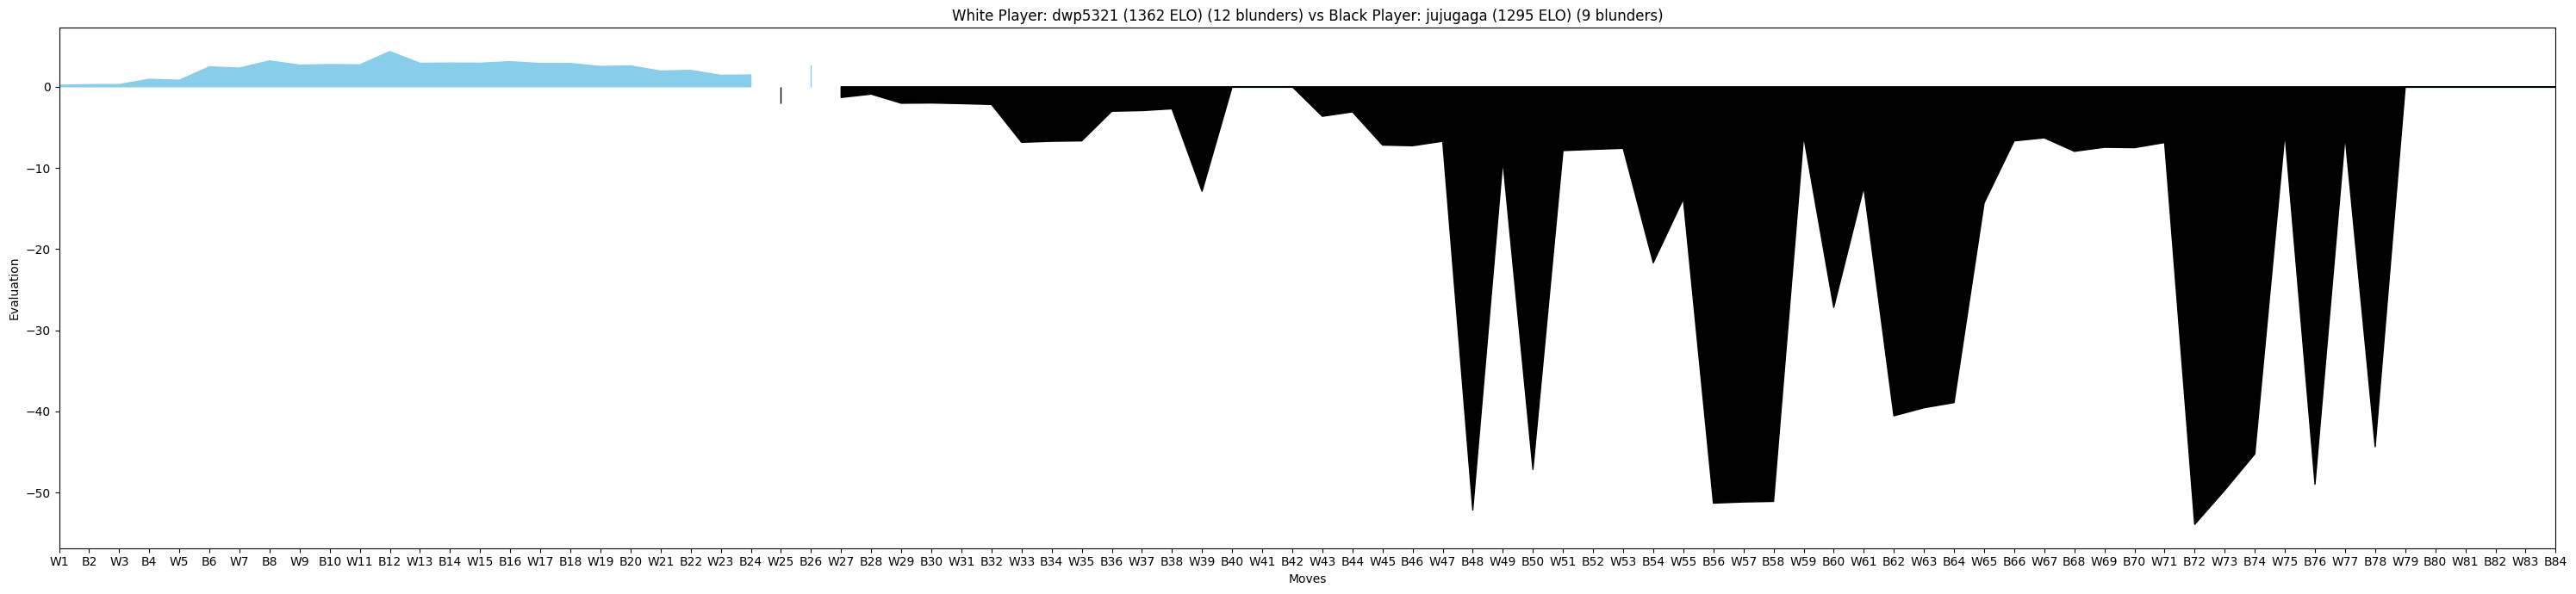

In [6]:
plot_eval_game(eval_games)

### Group By
- Time control ~ (60, 120, 180, 600) etc...
- Elo-Brackets ~ ([1200, 1400], [1500, 1700], [2000-2200]) etc...

#### Time Control Grouping

In [7]:
time_control_white_blunders_averages = eval_games \
    .groupBy("TimeControl") \
    .agg(mean("WhiteBlunders"), count("TimeControl")) \
    .withColumn("avg(WhiteBlunders)", format_number("avg(WhiteBlunders)", 1))

time_control_black_blunders_averages = eval_games \
    .groupBy("TimeControl") \
    .agg(mean("BlackBlunders"), count("TimeControl")) \
    .withColumn("avg(BlackBlunders)", format_number("avg(BlackBlunders)", 1))


In [8]:
time_control_white_blunders_averages \
    .orderBy(col("avg(WhiteBlunders)").desc()) \
    .where(col("count(TimeControl)")>10000) \
    .limit(10) \
    .toPandas() \
    .head()

2023-04-14 13:11:47,449 INFO datasources.FileSourceStrategy: Pushed Filters: IsNotNull(Eval)
2023-04-14 13:11:47,450 INFO datasources.FileSourceStrategy: Post-Scan Filters: isnotnull(Eval#10),isnotnull(cast(split(translate(Eval#10, ', ), ,, -1) as array<float>)[0])
2023-04-14 13:11:47,450 INFO datasources.FileSourceStrategy: Output Data Schema: struct<TimeControl: string, Eval: string>
2023-04-14 13:11:47,674 INFO codegen.CodeGenerator: Code generated in 114.524711 ms
2023-04-14 13:11:47,698 INFO memory.MemoryStore: Block broadcast_33 stored as values in memory (estimated size 487.1 KiB, free 87.9 MiB)
2023-04-14 13:11:47,729 INFO memory.MemoryStore: Block broadcast_33_piece0 stored as bytes in memory (estimated size 54.0 KiB, free 87.8 MiB)
2023-04-14 13:11:47,730 INFO storage.BlockManagerInfo: Added broadcast_33_piece0 in memory on namenode:45907 (size: 54.0 KiB, free: 92.7 MiB)
2023-04-14 13:11:47,732 INFO spark.SparkContext: Created broadcast 33 from toPandas at /tmp/ipykernel_2736

,TimeControl,avg(WhiteBlunders),count(TimeControl)


In [9]:
time_control_black_blunders_averages \
    .orderBy(col("avg(BlackBlunders)").desc()) \
    .where(col("count(TimeControl)")>100000) \
    .limit(10) \
    .toPandas() \
    .head()

2023-04-14 13:11:53,362 INFO datasources.FileSourceStrategy: Pushed Filters: IsNotNull(Eval)
2023-04-14 13:11:53,364 INFO datasources.FileSourceStrategy: Post-Scan Filters: isnotnull(Eval#10),isnotnull(cast(split(translate(Eval#10, ', ), ,, -1) as array<float>)[0])
2023-04-14 13:11:53,364 INFO datasources.FileSourceStrategy: Output Data Schema: struct<TimeControl: string, Eval: string>
2023-04-14 13:11:53,465 INFO memory.MemoryStore: Block broadcast_36 stored as values in memory (estimated size 487.1 KiB, free 91.2 MiB)
2023-04-14 13:11:53,492 INFO memory.MemoryStore: Block broadcast_36_piece0 stored as bytes in memory (estimated size 54.0 KiB, free 91.1 MiB)
2023-04-14 13:11:53,493 INFO storage.BlockManagerInfo: Added broadcast_36_piece0 in memory on namenode:45907 (size: 54.0 KiB, free: 93.1 MiB)
2023-04-14 13:11:53,494 INFO spark.SparkContext: Created broadcast 36 from toPandas at /tmp/ipykernel_273675/851957358.py:1
2023-04-14 13:11:53,497 INFO execution.FileSourceScanExec: Plannin

,TimeControl,avg(BlackBlunders),count(TimeControl)


#### Elo Brackets Grouping

Start off by Creating a new spark daraframe column called "EloBracket" which we will later use to group and aggregrate by. When grouping the players by elo brackets we want to use a range that makes sense such that there are not 1 bracket that contains 80% of the playerbase and ones that only contain a small fraction. E.g We want evenly distributed amount of players in each bracket (as far as that is possible).

2023-04-14 13:15:52,392 INFO datasources.FileSourceStrategy: Pushed Filters: IsNotNull(Eval)
2023-04-14 13:15:52,393 INFO datasources.FileSourceStrategy: Post-Scan Filters: isnotnull(Eval#10),isnotnull(cast(split(translate(Eval#10, ', ), ,, -1) as array<float>)[0])
2023-04-14 13:15:52,394 INFO datasources.FileSourceStrategy: Output Data Schema: struct<WhiteElo: int, Eval: string>
2023-04-14 13:15:52,443 INFO memory.MemoryStore: Block broadcast_62 stored as values in memory (estimated size 487.1 KiB, free 89.3 MiB)
2023-04-14 13:15:52,523 INFO storage.BlockManagerInfo: Removed broadcast_54_piece0 on datanode3:39179 in memory (size: 15.1 KiB, free: 366.2 MiB)
2023-04-14 13:15:52,533 INFO storage.BlockManagerInfo: Removed broadcast_54_piece0 on namenode:45907 in memory (size: 15.1 KiB, free: 92.9 MiB)
2023-04-14 13:15:52,536 INFO memory.MemoryStore: Block broadcast_62_piece0 stored as bytes in memory (estimated size 54.0 KiB, free 89.3 MiB)
2023-04-14 13:15:52,537 INFO storage.BlockManage

<Axes: ylabel='Density'>

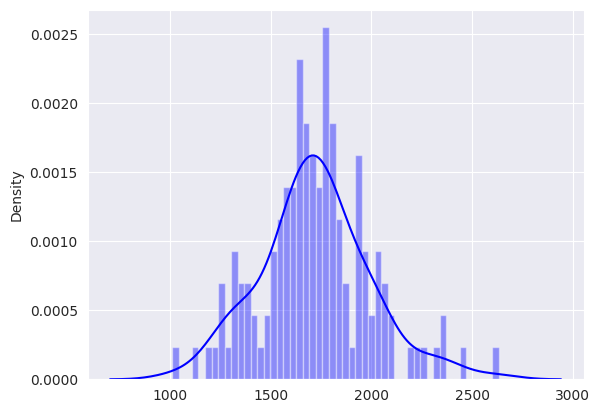

In [19]:
# Start by getting all the elo column values in the dataframe.
elo_list = eval_games.select(collect_list("WhiteElo")).first()[0]
sns.set_theme(style="ticks")
sns.set_style('darkgrid')
sns.distplot(elo_list, kde = True, bins = 50, color ='blue', palette="light:m_r", x="Elo",)

In [11]:
time_control_white_blunders_averages = eval_games \
    .groupBy("TimeControl") \
    .agg(mean("WhiteBlunders"), count("TimeControl")) \
    .withColumn("avg(WhiteBlunders)", format_number("avg(WhiteBlunders)", 1))

time_control_black_blunders_averages = eval_games \
    .groupBy("TimeControl") \
    .agg(mean("BlackBlunders"), count("TimeControl")) \
    .withColumn("avg(BlackBlunders)", format_number("avg(BlackBlunders)", 1))

In [12]:
a = eval_games.select("Moves") \
    .orderBy(col("WhiteBlunders").desc(), col("BlackBlunders").desc()) \
    .limit(1) \
    .take(1)[0][0]
print([x.replace("'","").replace('"', "").strip("'") for x in a])

2023-04-14 13:11:56,592 INFO storage.BlockManagerInfo: Removed broadcast_36_piece0 on namenode:45907 in memory (size: 54.0 KiB, free: 93.0 MiB)
2023-04-14 13:11:56,601 INFO storage.BlockManagerInfo: Removed broadcast_36_piece0 on datanode1:34043 in memory (size: 54.0 KiB, free: 366.3 MiB)
2023-04-14 13:11:56,609 INFO storage.BlockManagerInfo: Removed broadcast_35_piece0 on namenode:45907 in memory (size: 25.3 KiB, free: 93.0 MiB)
2023-04-14 13:11:56,611 INFO storage.BlockManagerInfo: Removed broadcast_35_piece0 on datanode1:36487 in memory (size: 25.3 KiB, free: 366.3 MiB)
2023-04-14 13:11:56,619 INFO storage.BlockManagerInfo: Removed broadcast_41_piece0 on namenode:45907 in memory (size: 15.1 KiB, free: 93.0 MiB)
2023-04-14 13:11:56,627 INFO storage.BlockManagerInfo: Removed broadcast_41_piece0 on datanode3:39179 in memory (size: 15.1 KiB, free: 366.3 MiB)
2023-04-14 13:11:56,634 INFO storage.BlockManagerInfo: Removed broadcast_37_piece0 on namenode:45907 in memory (size: 24.8 KiB, fr

['d4', ' Nf6', ' c4', ' Ng4', ' h3', ' Nxf2', ' Kxf2', ' d5', ' e3', ' dxc4', ' Bxc4', ' Be6', ' b3', ' Bxc4', ' bxc4', ' c5', ' Ne2', ' cxd4', ' Nxd4', ' e5', ' Qa4+', ' Nd7', ' Nf3', ' e4', ' Nfd2', ' f5', ' g4', ' fxg4', ' hxg4', ' Qf6+', ' Ke2', ' Qxa1', ' Nxe4', ' Qxb1', ' c5', ' Bxc5', ' Nxc5', ' O-O-O', ' Qxa7', ' Nxc5', ' Qxc5+', ' Kb8', ' Rh5', ' Qxa2+', ' Bd2', ' Rxd2+', ' Kf3', ' Qf7+', ' Rf5', ' Qd7', ' e4', ' Rd3+', ' Kf4', ' Rc8', ' Qe5+', ' Rd6', ' Qb2', ' g6', ' Rb5', ' Qf7+', ' Ke3', ' b6', ' e5', ' Rdc6', ' Rxb6+', ' Rxb6', ' Qxb6+', ' Qb7', ' Qd6+', ' Rc7', ' e6', ' Qb3+', ' Kf4', ' Kb7', ' e7', ' g5+', ' Kxg5', ' Qb5+', ' Kh6', ' Qe8', ' Kxh7', ' Qxe7+', ' Qxe7', ' Rxe7+', ' Kg6', ' Kc6', ' g5', ' Kd6', ' Kf6', ' Re8', ' g6', ' Kd7', ' g7', ' Rg8', ' Kf7', ' Rxg7+', ' Kxg7']


2023-04-14 13:11:57,022 INFO storage.BlockManagerInfo: Added broadcast_42_piece0 in memory on datanode3:43081 (size: 54.0 KiB, free: 366.2 MiB)
2023-04-14 13:11:57,143 INFO scheduler.TaskSetManager: Finished task 0.0 in stage 41.0 (TID 30) in 271 ms on datanode3 (executor 5) (1/1)
2023-04-14 13:11:57,143 INFO cluster.YarnScheduler: Removed TaskSet 41.0, whose tasks have all completed, from pool 
2023-04-14 13:11:57,144 INFO scheduler.DAGScheduler: ResultStage 41 (take at /tmp/ipykernel_273675/2574037976.py:1) finished in 0.291 s
2023-04-14 13:11:57,144 INFO scheduler.DAGScheduler: Job 30 is finished. Cancelling potential speculative or zombie tasks for this job
2023-04-14 13:11:57,144 INFO cluster.YarnScheduler: Killing all running tasks in stage 41: Stage finished
2023-04-14 13:11:57,146 INFO scheduler.DAGScheduler: Job 30 finished: take at /tmp/ipykernel_273675/2574037976.py:1, took 0.295238 s
2023-04-14 13:11:57,170 INFO codegen.CodeGenerator: Code generated in 16.090196 ms
